# Reference Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
sns.set()

We generate reference data by simulating the epidemic with no contact tracing. Through this, we can gain an understanding of how well contact tracing is able to control the epidemic in terms of a growth rate reduction.

This is done using the simulation script - "Simulate_growth_rates_no_tracing.py"

In [3]:
# Import the data
reference_data = pd.read_excel("Data/Reference/growth_rates_no_tracing.xlsx", index_col = 0)

In [4]:
reference_data

,infection_reporting_prob,global_contact_reduction,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0.1,0.0,5000,5090,5614,6966,9314,12544,16728,21782,...,44978,56982,71513,89730,112513,140947,176274,220376,275081,342810
1,0.2,0.0,5000,5082,5605,6998,9262,12678,17006,22103,...,45563,57614,72529,91487,114722,143590,179834,225231,281049,351064
2,0.3,0.0,5000,5074,5607,7020,9450,12925,17374,22738,...,47274,59865,75773,95595,120038,150585,188737,235943,295329,368844
3,0.4,0.0,5000,5090,5632,7068,9523,12978,17298,22498,...,46551,58945,74331,93373,117227,147225,184407,231024,288912,361612
4,0.5,0.0,5000,5088,5641,7052,9546,13012,17495,22805,...,47497,60134,75945,95205,119468,149595,187057,233807,292640,365540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.5,0.9,5000,5022,5145,5429,5866,6458,7025,7507,...,8400,8628,8798,8919,9052,9139,9221,9287,9336,9375
446,0.6,0.9,5000,5017,5145,5459,5957,6505,7099,7545,...,8475,8670,8853,8998,9113,9209,9283,9341,9387,9423
447,0.7,0.9,5000,5018,5164,5466,5933,6487,7060,7493,...,8309,8494,8638,8765,8866,8933,8995,9049,9092,9128
448,0.8,0.9,5000,5021,5124,5432,5946,6543,7104,7598,...,8373,8538,8680,8811,8910,8985,9037,9081,9128,9157


In [5]:
# Create variable for easy subsetting of column counts
infection_count_col_names = [str(i) for i in range(20)]

In [6]:
data_subset = reference_data[infection_count_col_names]

In [7]:
# Fitting OLS regressions to estimate the growth rate
growth_rates = []

# Loop over rows
for _ in range(data_subset.shape[0]):
    
    print(f"current fit; {_}", end = "\r")
    
    # Difference to get the incidence and take the log to get the growth
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    # make a dataframe
    data_set_up = {
        "log_case_incidence": log_diff[10:20],
        "time": list(range(10, 20))
    }
    dataframe = pd.DataFrame(data_set_up)
    
    # Create design matrix and regress
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    # If the initial starting value of the epidemic is not high enough you can get missing data
    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

Text(0, 0.5, 'Frequency')

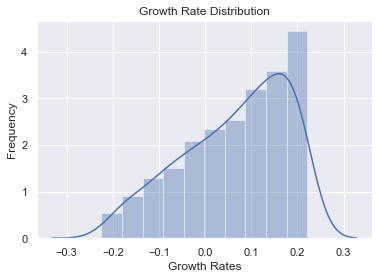

In [8]:
sns.distplot(growth_rates)
plt.title("Growth Rate Distribution")
plt.xlabel("Growth Rates")
plt.ylabel("Frequency")

In [9]:
results = reference_data[["global_contact_reduction", "infection_reporting_prob"]]

In [10]:
results["growth_rate"] = pd.Series(growth_rates)

C:\Users\mfyles\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Create a data table of the observed growth rate and 

In [11]:
results

,global_contact_reduction,infection_reporting_prob,growth_rate
0,0.0,0.1,0.218568
1,0.0,0.2,0.220847
2,0.0,0.3,0.220671
3,0.0,0.4,0.220804
4,0.0,0.5,0.218835
...,...,...,...
445,0.9,0.5,-0.203700
446,0.9,0.6,-0.224432
447,0.9,0.7,-0.198868
448,0.9,0.8,-0.214557


Text(0.5, 0, '% reduction in global contacts')

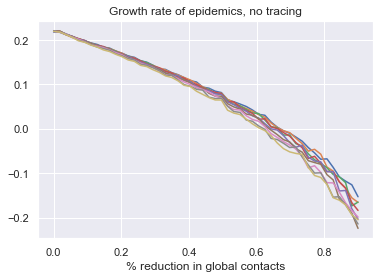

In [12]:
for infection_report_value in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    
    subset = results[results["infection_reporting_prob"] == infection_report_value]
    
    plt.plot("global_contact_reduction", "growth_rate", data = subset)
    
plt.title("Growth rate of epidemics, no tracing")

plt.xlabel("% reduction in global contacts")

There's some pretty clear heteroscedasticity in the results. We estimate the mean growth rate using robust linear regression to cope with it (I tried iteratively reweighted least squares but can't figure it out at the moment).

In [13]:
y, X = dmatrices('growth_rate ~ global_contact_reduction + I(global_contact_reduction**2)',
                 data = results)
model = sma.RLM(y, X)
res = model.fit()
print(res.summary())
#sm.graphics.regressionplots.plot_fit(res, "global_contact_reduction")

                    Robust linear Model Regression Results                    
Dep. Variable:            growth_rate   No. Observations:                  450
Model:                            RLM   Df Residuals:                      447
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 11 May 2020                                         
Time:                        14:07:59                                         
No. Iterations:                    39                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

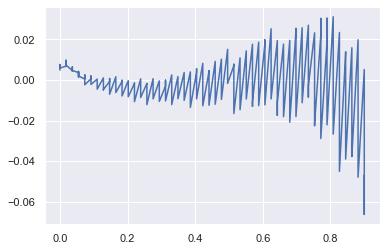

In [14]:
plt.plot(results["global_contact_reduction"], res.resid)

Not great but will do for now.

In [15]:
results["OLS_resid"] = abs(res.resid)
y, X = dmatrices('growth_rate ~ global_contact_reduction + I(global_contact_reduction**2)',
                 data = results)
model_2 = sma.RecursiveLS(y, X)
res_2 = model_2.fit()
print(res.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:            growth_rate   No. Observations:                  450
Model:                            RLM   Df Residuals:                      447
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 11 May 2020                                         
Time:                        14:08:25                                         
No. Iterations:                    39                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

C:\Users\mfyles\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


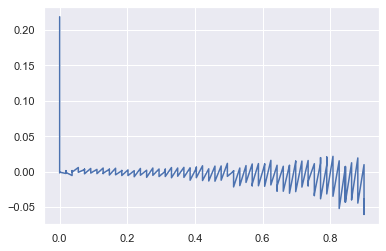

In [16]:
plt.plot(results["global_contact_reduction"], res_2.resid)

In [17]:
res_2.resid

array([ 2.18568411e-01,  2.27857127e-03,  9.63587939e-04,  7.74746984e-04,
       -1.38734676e-03,  3.38448794e-05,  3.98757752e-04,  1.28377589e-03,
       -6.25540109e-04, -2.51026072e-03,  1.25188046e-03,  1.35447023e-03,
        1.49972462e-03,  1.56277421e-04,  1.43263432e-03, -1.46694316e-03,
       -6.44052702e-04, -9.49692742e-04, -5.41479172e-03, -2.53767339e-04,
        1.00833883e-03,  1.59548436e-04,  1.54495624e-03,  9.15095077e-05,
        6.78208618e-04,  7.48985538e-05, -6.37825709e-04,  5.90246442e-03,
       -3.26109161e-04,  2.22591439e-03,  1.94875265e-03,  1.29929227e-03,
        4.86573405e-04, -6.14382494e-04, -7.24015918e-04, -8.73508088e-04,
        3.00695183e-03,  3.65078399e-03,  2.25551669e-03,  1.67144388e-03,
        5.16444317e-05, -9.77172428e-04,  4.37449107e-04, -1.82277082e-03,
       -2.98156882e-03,  4.55779673e-03,  3.76469917e-03,  2.96995631e-03,
        2.86071446e-03,  2.38350592e-03,  6.22111804e-04, -9.79048995e-04,
       -1.39242319e-03, -

In [388]:
df = pd.DataFrame([res.params], columns = ["intercept", "coef_contact_reduction", "coef_contact_reduction**2"])

In [389]:
df.to_excel("Data/Reference/OLS_coefficients.xlsx")

In [370]:
a = np.ones(50)
b = np.linspace(0, 0.8)
c = b**2
design = np.array(list(zip(a,b,c)))

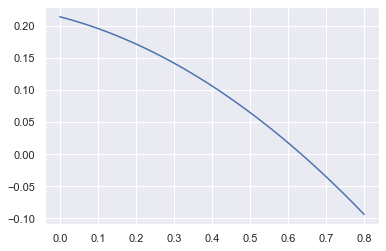

In [374]:
x = np.linspace(0, 0.8)
fig, ax = plt.subplots()
ax.plot(x, predict.predicted_mean)

In [375]:
lower = predict.conf_int(0.5)[:, 0]
upper = predict.conf_int(0.5)[:, 1]

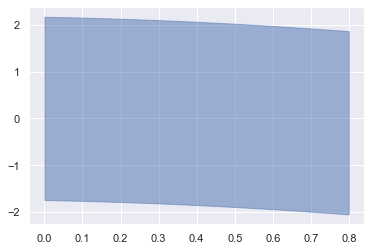

In [376]:
x = np.linspace(0, 0.8)
fig, ax = plt.subplots()
#ax.plot(x, predict.predicted_mean)
ax.fill_between(x, lower, upper, color='b', alpha=.5)
plt.show()